# MNIST handwritten digits

Classifying handwritten digits using a neural network in pytorch.

Referring to the pytorch tutorials at https://pytorch.org/tutorials/beginner/basics/intro.html.

Got to 95% accuarcy, but haven't used pooling, normalisation, regularisation, or optimisation algorithms beyond SGD yet.

## Getting the data

In [1]:
# Packages and modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Functions and classes
from torchvision.transforms import ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
# Download and/or load dataset (thanks Yann), and transform to tensors, and one-hot encodings
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
train = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)
test = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)

# Make dataloader
train_dataloader = DataLoader(train, batch_size=3)

# Enumerate training dataloader
examples = enumerate(train_dataloader)

# Get first batch of samples and check shape
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([3, 1, 28, 28])
torch.Size([3, 10])


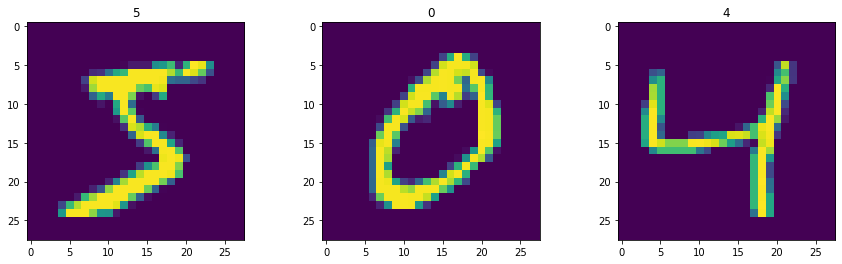

In [3]:
# Show first few inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{example_targets[i].argmax(0)}")
plt.show()

## Convolutional neural network

In [4]:
# Breakdown modelling functions
X = torch.rand(1, 1, 28, 28)
X = example_data[:1]
print(f"Input: {X.shape}")
X_conv = nn.Conv2d(1, 2, 27)(X)
print(f"Convolved: {X_conv.shape}")
X_flat = nn.Flatten()(X_conv)
print(f"Flattened: {X_flat.shape}")
X_l = nn.Linear(8, 4)(X_flat)
print(f"Linear: {X_l}")
X_r = nn.ReLU()(X_l)
print(f"ReLU: {X_r}")
logits = nn.Linear(4, 4)(X_r)
print(f"Model: {logits}")
pred_probab = nn.Softmax(dim=1)(logits)
print(f"Probabilities: {pred_probab}")
print(f"Predicted class: {pred_probab.argmax(1)}")

Input: torch.Size([1, 1, 28, 28])
Convolved: torch.Size([1, 2, 2, 2])
Flattened: torch.Size([1, 8])
Linear: tensor([[ 0.0795,  0.2024, -0.3934, -0.1500]], grad_fn=<AddmmBackward0>)
ReLU: tensor([[0.0795, 0.2024, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Model: tensor([[ 0.1247, -0.2187, -0.0254, -0.2707]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.3083, 0.2187, 0.2653, 0.2076]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([0])


In [5]:
# Create neural network model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.seq_modules = nn.Sequential(
            nn.Conv2d(1, 5, 5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5*24*24, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        logits = self.seq_modules(x)
        return logits

## Create model on GPU

In [6]:
# Set device to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
# Create neural network model
conv_model = NeuralNetwork().to(device)
print(conv_model)

NeuralNetwork(
  (seq_modules): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2880, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [8]:
# Use model to get predictions
conv_model(X.to(device))

tensor([[ 0.2033,  0.1007,  0.1612,  0.0274,  0.1291,  0.0337,  0.0519, -0.0132,
         -0.1023,  0.0754]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [9]:
name, param = next(conv_model.named_parameters())
print(f"Layer: {name}")
print(f"Size: {param.size()}")
print(f"Values : {param[:1]} \n")

Layer: seq_modules.0.weight
Size: torch.Size([5, 1, 5, 5])
Values : tensor([[[[-0.1281,  0.1973,  0.0121, -0.0615,  0.0411],
          [-0.0264,  0.1325, -0.0153,  0.0262, -0.1605],
          [ 0.1991,  0.0947, -0.1223, -0.0998, -0.1491],
          [ 0.1343, -0.0689,  0.0559, -0.1853,  0.1530],
          [ 0.1684, -0.0269,  0.1262,  0.0477,  0.0551]]]], device='cuda:0',
       grad_fn=<SliceBackward0>) 



## Find batch size

In [10]:
# Training and testing functions
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

In [25]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Make dataloader
train_dataloader = DataLoader(train, batch_size=64)

In [26]:
%%time
train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.231261  [    0/60000]
loss: 0.208701  [ 6400/60000]
loss: 0.272013  [12800/60000]
loss: 0.271806  [19200/60000]
loss: 0.124443  [25600/60000]
loss: 0.272358  [32000/60000]
loss: 0.137172  [38400/60000]
loss: 0.175525  [44800/60000]
loss: 0.203162  [51200/60000]
loss: 0.193900  [57600/60000]
Wall time: 11.3 s


In [27]:
# Make dataloader
train_dataloader = DataLoader(train, batch_size=256)

In [28]:
%%time
train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.244115  [    0/60000]
loss: 0.128569  [25600/60000]
loss: 0.121730  [51200/60000]
Wall time: 9.17 s


In [29]:
# Make dataloader
train_dataloader = DataLoader(train, batch_size=512)

In [30]:
%%time
train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.135540  [    0/60000]
loss: 0.094147  [51200/60000]
Wall time: 8.62 s


In [31]:
# Make dataloader
train_dataloader = DataLoader(train, batch_size=1024)

In [32]:
%%time
train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.115561  [    0/60000]
Wall time: 8.48 s


## Find learning rate

In [33]:
test_dataloader = DataLoader(test, batch_size=1024)

conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-3)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.307622  [    0/60000]
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.304768 



In [34]:
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-2)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.312024  [    0/60000]
Test Error: 
 Accuracy: 16.0%, Avg loss: 2.255195 



In [35]:
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-1)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.313684  [    0/60000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.524720 



In [36]:
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e0)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.296094  [    0/60000]
Test Error: 
 Accuracy: 10.4%, Avg loss: 2.301390 



## Train model

In [37]:
lr = 1e-1
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr)

In [38]:
last_correct = 0
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, conv_model, loss_fn, optimizer)
    correct = test_loop(test_dataloader, conv_model, loss_fn)
    diff = correct - last_correct 
    if diff < 0.01:
        if diff > 0:
            lr /= 2
            optimizer.param_groups[0]['lr'] = lr
            last_correct = correct
        else:
            break
            
print("Done!")

Epoch 1
-------------------------------
loss: 2.314094  [    0/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.424140 

Epoch 2
-------------------------------
loss: 0.464001  [    0/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.327802 

Epoch 3
-------------------------------
loss: 0.350327  [    0/60000]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.276869 

Epoch 4
-------------------------------
loss: 0.292232  [    0/60000]
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.241037 

Epoch 5
-------------------------------
loss: 0.252839  [    0/60000]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.216323 

Epoch 6
-------------------------------
loss: 0.223936  [    0/60000]
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.198004 

Epoch 7
-------------------------------
loss: 0.203515  [    0/60000]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.183297 

Epoch 8
-------------------------------
loss: 0.186441  [    0/60000]
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.171511 

Epoch 9
----------------

## Check predictions

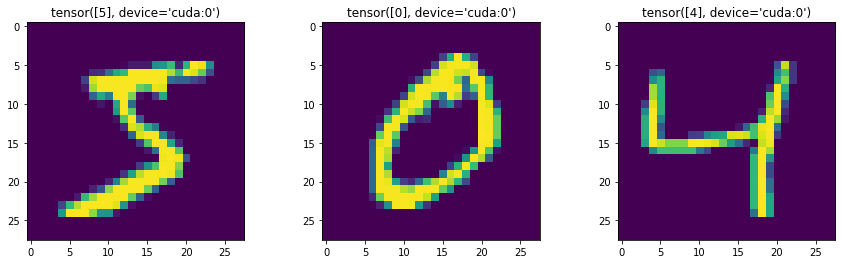

In [39]:
# Show first few sample inputs and predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{conv_model(example_data[i:(i+1)].to(device)).argmax(1)}")
plt.show()

## Save/load model

In [42]:
# torch.save(conv_model, 'models/conv_mnist')

In [41]:
# conv_model = torch.load('models/conv_mnist')